# Earth Launcher

*By Shashank Swaminathan and Timothy Novak*

The following code configures the notebook and imports relevant libraries

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'
# import functions from the modsim.py module
from modsim import *
import numpy as np

Units are included for readability in some parts of the code. They were originally defined using the units library, but because solver functions got rid of units it became troublesome to ensure consistency throughout the code. We have redefined them as 1 to avoid conflicts and errors.

In [2]:
m = 1 # UNITS.meter
s = 1 # UNITS.second
year = 1 # UNITS.year
kg = 1 # UNITS.kilogram
A = 1 # UNITS.ampere
V = 1 # UNITS.volts
Ohm = 1 # UNITS.ohm
N = 1 # UNITS.newton
U_mu = N / A**2
None

# Question

What are the design requirements for a railgun such that firing the railgun can accelerate the earth to the escape velocity of the sun?

The above modeling question might seem highly rediculous, hovever similar situations are being studied as spacecraft launch systems. One example is the electromagnetic mass driver which is a hypothetical concept of using a electromagnetically powered cannon, like a railgun or coilgun, to accelerate spacecraft for launch (see Applications section of the following page: https://en.wikipedia.org/wiki/Railgun or the dedicated page on the subject https://en.wikipedia.org/wiki/Mass_driver) This project models the reverse situation where the momentum gennerated by the shot is intended to accelerate the earth rather than to accelerate a projectile.

# Railgun Model

First steps first, we define important railgun parameters that we will use in the simulation:
 - Railgun length: 10 kilometers.
 - Starting position of the armature (projectile): 0 meters.
 - Diameter of the actual railgun: Half a meter.
 - Radius of the railgun rods: 0.05 meters.
 - Mass of the armature: 1 kilogram. (This is subject to change per simulation.)
 - Voltage Supply to the railgun: 1000 V. (This is subject to change per simulation.)
 - Resistance of the railgun circuit: 1e-10 Ohms (representing near super-conductivity).
 - Vacuum Permeability: An SI defined constant.
 - Simulation end time (if an event has not already stopped simulation): 1 year.

In [3]:
params_railgun = Params(x = 0 * m, 
                        d = 0.5 * m,
                        r = 0.05 * m,
                        L = 10e3 * m,
                        mass = 1 * kg,
                        Vs = 1000 * V,
                        R = 1e-10 * Ohm,
                        mu_0 = 1.257e-6 * U_mu,
                        t_end = 1 * year)

,values
x,0.000000e+00
d,5.000000e-01
r,5.000000e-02
L,1.000000e+04
mass,1.000000e+00
Vs,1.000000e+03
R,1.000000e-10
mu_0,1.257000e-06
t_end,1.000000e+00


The next step is to make a function that takes these parameters and returns a more optimized System object that will be used in simulation. The System object's contents are described in its docstring.

In [4]:
def make_railgun_system(params):
    """
    Make a system object.
    
    Parameters:
        params: Params object containing following:
            x: Initial position of armature (in meters)
            d: Separation distance between two rails (in meters)
            r: Radii of the rails (in meters)
            L: Length armature has to travel along rails before launch (in meters)
            mass: Mass of armature (in kilograms)
            Vs: (Initial) Voltage supply magnitude (in volts)
            R: Resistance of railgun circuit (in ohms)
            mu_0: Vacuum permeability constant (in N/A^2)
            t_end: Simulation end time (in seconds)
               
    returns: System object containing
        params values
        c_mag: Calculated magnetic force coefficient (in N/A^2)
        init: Initial state object containing:
            x: Position of armature (initialized to params.x) (in meters)
            v: Velocity of armature (initialized to 0) (in meters)
    """
    
    # make the initial state
    init = State(x=params.x, v=0)
    
    # Determine magnetic force coefficient
    c_mag = params.mu_0 * log((params.d - params.r) / params.r) / (2 * pi)
    
    return System(params, c_mag = c_mag, init=init)

For simulating a railgun, the most important (and what we assume as the only active) force is the magnetic force formed from the rails and moving armature. This can be described via the equation 

$
\begin{equation}
F_{mag} = \frac{\mu_0 * I ^2 * \log(\frac{d-r}{r})}{2\pi}
\end{equation}$

We simplify this by abstracting out the constants into a value called $c_{mag}$ (which was created in the **make_system** function). This leaves the following equation for magnetic force, which is used in the magnetic force function defined in the cell below: 

$
\begin{equation}
    F_{mag} = c_{mag} * I^2
\end{equation}
$

In [5]:
def mag_force(I, system):
    """
    Determines magnetic force on armature due to magnetic loop of railgun. 
    Assumes 1D system.
    
    Parameters:
        I: Current through the circuit at time of function call. (in amperes)
        system: System object containing following system parameters (relevant listed):
            c_mag: Calculated magnetic force coefficient (in N/A^2)
               
    returns: Magnitude of magnetic force
    """
    return system.c_mag * I**2

To simulate this system we are going to use $modsim.py$'s wrapper function for **solve_ivp**, **run_ode_solver**, and so we now create a slope function that will wrap the magnetic force function from earlier and create derivatives for simulation:

In [6]:
def railgun_slope_func(state, t, system):
    """
    Computes derivatives of the state variables. 
    Invokes function mag_force to determine magnetic force applied on armature.
    
    Parameters:
        state: Current State object at time of function call.
            x: Position of armature (initialized to params.x) (in meters)
            v: Velocity of armature (initialized to 0) (in meters)
        system: System object containing following system parameters (relevant listed):
            Vs: Magnitude of voltage supply to circuit (in volts)
            R: Resistance of the circuit (in ohms)
               
    returns: Magnitude of magnetic force (in newtons)
    """
    x, v = state

    I = system.Vs / system.R
    
    F_mag = mag_force(I, system)
    a = F_mag / system.mass
    
    return v, a

Finally, we introduce an event that will halt the simulation once it occurs: the position of the armature reaching the end of the railgun (and therefore launching from the railgun).

In [7]:
def event_func_railgun(state, t, system):
    """
    Stop when the position is equal to the length of rail that can be traveled.
        (stop when the distance left to travel is equal to 0)
    
    Parameters:
        state: Current State object at time of function call.
            x: Position of armature (initialized to params.x) (in meters)
            v: Velocity of armature (initialized to 0) (in meters)
        system: System object containing following system parameters (relevant listed):
            L: Length armature has to travel along rails before launch (in meters)
               
    returns: Distance the armature has left to travel.
    """
    x, v = state
    return x - system.L

We wrap the slope and event functions from earlier into another function, which we will name **sim_railgun**. This function will run the solver function around the **railgun_slope_function**, and will halt the simulation once the event defined in the **event_func_railgun** occurs. The returned values from this simulation function will the the position and velocity of the armature over time; these will then be used by the functions defined in the following section, the ones which describe the motion of the planetery bodies in both stable and perturbed orbits.

In [8]:
def sim_railgun(mass, v_supply, params, max_step = 0):  
    """
    Simulate the railgun model.
    
    Parameters:
        mass: Mass of armature (in kilograms)
        params: Params object containing following:
            x: Initial position of armature (in meters)
            d: Separation distance between two rails (in meters)
            r: Radii of the rails (in meters)
            L: Length armature has to travel along rails before launch (in meters)
            mass: Mass of armature (in kilograms)
            Vs: (Initial) Voltage supply magnitude (in volts)
            R: Resistance of railgun circuit (in ohms)
            mu_0: Vacuum permeability constant (in N/A^2)
            t_end: Simulation end time (in seconds)
               
    returns:
        x: Final position of the armature.
        v: Final velocity of the armature.
    """
    params = Params(params, mass=mass, Vs = v_supply)
    system = make_railgun_system(params)
    if max_step == 0:
        results, details = run_ode_solver(system,
                                          railgun_slope_func,
                                          events=event_func_railgun)
    else:
        results, details = run_ode_solver(system,
                                          railgun_slope_func,
                                          events=event_func_railgun, 
                                          max_step = 1e-16)
    return results.x, results.v

# Planetary Motion Model code
The following functions describe the planitary motion simulation

The following code describes the main function which is used in running simulations of a planet in orbit around the sun. This function returns a time frame detailing the velocity and position of the plenet at varous points in time.

In [9]:
def run_planet_simulation (earth_position_x, 
                           earth_position_y,
                           earth_velocity_x,
                           earth_velocity_y,
                           earth_mass,num_years):
    """This function runs a simulation of a two body planetary system. 
    This simulation assumes:
        The sun in the planetary system has the mass of earth's sun,
        and is at a fixed location in space (0,0) for convenience.
    The planet's position velocity and mass are supplied,
        to better inform the simulation.
    The number of years dictates how many years the simulation should be run for.
    Max_step_size is the maximum step size in seconds.
    The function returns the trajectory of the supplied planet."""
    # creates the state for the simulation
    #distance in meteres velocity in m/s
    st8 = State(xpos = earth_position_x, 
                ypos = earth_position_y, 
                xvel = earth_velocity_x, 
                yvel = earth_velocity_y)
    #Creates a system which holds the parameters of the simulation
    #G = m^3/(kg*s^2)
        # masses are in kg
        # radi are in meters 
        # velocities are in m/s
    sys = System(init = st8,
                 G = 6.67408*10**(-11) * (m**3)/(kg*s**2), 
                 M_earth = earth_mass, 
                 M_sun =1.989*10**30*kg, 
                 R_earth = 6.3781*10**6*m, 
                 R_sun= 6.95700*10**8*m, 
                 t_end = num_years*s/year,#60*60*24*365.25
                 Earth_Radius = 6378*10**3*m,
                 sun_pos = Vector(0*m,0*m))
    
    #runs an ODE solver to run the simulation -
        # restricts the ODE solver to taking steps with a maximum size of one day
#     ts = linrange(0, 32*10**6, 1000)
    results,details = run_ode_solver(sys,planet_slope_func, max_step=60*60*24*s)
    results.xpos *= m
    results.ypos *= m
    results.xvel *= m/s
    results.yvel *= m/s
    
    #returns the results of the solver
    return results

The following function  performs the momentum conservation calculations on the earth. This function returns an updated mass and velocity of the earth based on the change in momentum from the firing of a projecile with a given mass and velocity.

In [10]:
def fire_cannon(planet_velocity_vector,
                Mass_earth,
                Mass_shot,
                Shot_speed):
    """
    Runs a function which:
        updates the velocity and mass of a planet
        Assumes it is accelerated via mass ejection.
    Calculations are based on conservation of momentum.
    Masses are in kilograms
    Speeds are in m/s
    The velocity vector describes the last known velocity of the planet.
    MODELING ASSUMPTION CONSTRAINT:
        The model assumes the earth exerts no gravitational pull on the projectile.
        Implies projectiles fired at less than escape velocity will not be accurate
            Does not account for where they would fall back to the earth."""
    if Shot_speed != 0*m/s:
        #calculates the magnitude of the new velocity of the planet
        velocity_vector_magnitude = (Mass_earth*planet_velocity_vector.mag + \
                                     Mass_shot*Shot_speed)/(Mass_earth-Mass_shot) 

        #This creates a velocity vector in the direction of the previous velocity
        planet_vel_unit_vector = planet_velocity_vector/planet_velocity_vector.mag
        #multiplies magnitude by the unit vector to get a vector in the proper direction with the proper magnitude
        planet_velocity_vector = planet_vel_unit_vector * velocity_vector_magnitude
        #updates the mass of the earth to account for shot's mass leaving earth
        Mass_earth = Mass_earth - Mass_shot
    
    #retuns the new velocity as a vector and the new mass of the earth
    return planet_velocity_vector, Mass_earth

The remaining functions expand upon the above functions in more detail. The in depth explanation can be skipped by proceding to the **Combined Launch Model Code** section below.

In [11]:
def planet_slope_func(st8, t, sys):
    """
    Describes the change in:
        position and velocity in both the x and y plane.
    The function takes in a state which describes the old position of the system
    t is the time of the syatem -
        it is not actually used in calculations
        it is a required argument for use with an ODE Solver.
    sys is a system object which contains system constants
    """
    
    #extracts the values from the state
    #This is as the ODE solver does not store variables in a state object
    xpos,ypos,xvel,yvel= st8
    #creates a vector which describes the position of the planet
    planet_pos = Vector(xpos,ypos)
    
    #describes a system of differential equations
    #update the velocity in each direction
    dxveldt = get_grav_acceleration(sys.G, sys.M_sun, sys.M_earth,
                                    planet_pos,sys.sun_pos).x
    dyveldt = get_grav_acceleration(sys.G, sys.M_sun, sys.M_earth,
                                    planet_pos,sys.sun_pos).y
    
    #update the position in each direction
    dxposdt = xvel
    dyposdt = yvel
    
    #returns the change in the state variables
    return dxposdt,dyposdt,dxveldt,dyveldt

This function finds the magnitude of the gravitational acceleration on a planet by the sun using F = ma. The function returns the acceleration in terms of m/s^2.

In [12]:
def get_grav_acceleration(G, M1, m2, planet_vector, sun_vector):
    """
    Calculates acceleration due to gravity with F = ma
    F in N
    masses in kg
    a in m/s^2
    """
    #gets the force & divides by the orbiting body to finding orbital acceleration
    return get_gravitational_force(G,M1,m2,planet_vector,sun_vector)/m2

The following function applies the law of universal gravitation to find the magnitude of the gravitational force for a planet orbiting a star. The function retunrs a force in N which describes the gravitational force.

In [13]:
def get_gravitational_force(G,M1,m2,planet_vector, sun_vector):
    """
    Applies law of universal gravitation 
    Returns the force of gravity as a vector towards the center of the circle
    in N
    """
    #calculates the vector pointing from the planet to the sun
    planet_to_sun_vector = sun_vector-planet_vector
    
    #takes the direction of the previous vector
    Direction_vector = planet_to_sun_vector/planet_to_sun_vector.mag
    
    #calculates the acceleration of the planet
    acceleration_mag = (G*M1*m2)/(planet_vector.mag**2)
    
    #Returns a vector which has:
        # Magnitude of the acceleration 
        # Direction towards the star
    return Direction_vector * acceleration_mag

# Combined Launch Model Code

The following function runs a simulation of firing the railgun and the effect which this action has on the orbit of the earth. The function returns a time frame describing the earth's position and velocity at various points in time after firing the railgun.

In [14]:
def launch_simulation(mass_armature,
                      railgun_voltage,
                      railgun_params,
                      orbital_results):
    """This function runs a simulation of the launch of a projectile """
    
    # Simulate railgun launch
    rail_x, rail_v = sim_railgun(mass_armature * kg,
                                 railgun_voltage,
                                 railgun_params)
    
    final_armature_speed = get_last_value(rail_v)
    
    #gets a vector of the velocity of earth
    #This is based on the results of the original simulation
    orbital_velocity = Vector(get_last_value(orbital_results.xvel*m),
                              get_last_value(orbital_results.yvel*m))
    
    #fires the railgun    
    post_cannon_earth_velocity, post_cannon_earth_mass = fire_cannon(orbital_velocity,
                                                         5.972*10**24*kg,
                                                         mass_armature,
                                                         final_armature_speed)
    return post_cannon_earth_velocity, post_cannon_earth_mass

# Optimization

This code takes a voltage supply value and a set of parameters, and calculates the final velocity of the planetary body that has had a projectile launched from it using a railgun (described within the parameter set). It relies on the functions defined prior to this cell. Its purpose is to allow ease of optimization (using the $fsolve$ function) of the final velocity of the launched planetary body, based on voltage supply input to the railgun.

In [15]:
def voltage_optimizer(Vs, sim_params):
    """
    Used to find minimum voltage required to achieve escape velocity.
    
    Parameters:
        Vs: Voltage supply to the railgun 
            To be optimized using fsolve.
        sim_params: Additional parameters ued in simulation (held constrant)
            mass: Mass of armature shooting from Earth.
            railgun: Railgun parameters
            orbital_results: Current state of a stable Earth in orbit.
               
    Returns: 
        The difference of Earth's velocity post railgun launch, 
        and the theoretical escape velocity value.
    """
    res_v, res_m = launch_simulation(sim_params.mass,
                              Vs,
                              sim_params.railgun,
                              sim_params.orbital_results)
    return res_v.mag - sim_params.v_escape

To do optimizing of the mass based on voltage supply, we do the same as the function above once again, this time changing the optimized variable from voltage supply to mass.

In [16]:
def mass_optimizer(mass, sim_params):
    """
    Used to find minimum voltage required to achieve escape velocity.
    
    Parameters:
        mass: Mass of armature shooting from Earth.
              To be optimized using fsolve.
        sim_params: Additional parameters ued in simulation (held constrant)
            Vs: Voltage supply to the railgun
            railgun: Railgun parameters
            orbital_results: Current state of a stable Earth in orbit.
               
    Returns: 
        The difference of Earth's velocity post railgun launch, 
        and the theoretical escape velocity value.
    """
    res_v, res_m = launch_simulation(mass,
                              sim_params.Vs,
                              sim_params.railgun,
                              sim_params.orbital_results)
    return res_v.mag - sim_params.v_escape

# Results

The following code describes the inital state of the earth. values have been chosen to place the earth at a distance of one astronomical unit (AU) away from the sun (the average distance from the earth to the sun), moving at a velocity which corrasponds to the observed velocity withwhich the earth orbits the sun (assuming a nearly circular orbit and a distance from the sun of 1 AU), and the measured mass of the earth.
The simulation is set to run for one year to demonstrate earth in stable orbit before the railgun is fired.

In [30]:
#Describes the inital position, in vector format, of the earth (m)
inital_earth_x_position = 149597900000*m
inital_earth_y_position = 0*m

#Describes the inital velocity, in vector format, of the earth (m/s)
inital_earth_x_velocity = 0*m/s
inital_earth_y_velocity = 29785*m/s

#Describes the inital mass of the earth (kg)
inital_earth_mass = 5.972*10**24*kg

#Describes the length of the stable orbit simulation (years)
stable_orbit_simulation_runtime = 365.25*60*60*24*s
None

In [31]:
orbital_results = run_planet_simulation(inital_earth_x_position,
                                        inital_earth_y_position,
                                        inital_earth_x_velocity,
                                        inital_earth_y_velocity,
                                        inital_earth_mass,
                                        stable_orbit_simulation_runtime) 


,xpos,ypos,xvel,yvel
0.000000e+00,1.495979e+11,0.000000e+00,0.000000e+00,29785.000000
4.748073e-08,1.495979e+11,1.414214e-03,-2.816389e-10,29785.000000
5.222880e-07,1.495979e+11,1.555635e-02,-3.098027e-09,29785.000000
5.270361e-06,1.495979e+11,1.569777e-01,-3.126191e-08,29785.000000
5.275109e-05,1.495979e+11,1.571191e+00,-3.129008e-07,29785.000000
5.275584e-04,1.495979e+11,1.571333e+01,-3.129289e-06,29785.000000
5.275631e-03,1.495979e+11,1.571347e+02,-3.129318e-05,29785.000000
5.275636e-02,1.495979e+11,1.571348e+03,-3.129320e-04,29785.000000
5.275637e-01,1.495979e+11,1.571348e+04,-3.129321e-03,29785.000000
5.275637e+00,1.495979e+11,1.571348e+05,-3.129321e-02,29785.000000


The following code runs a simulation which sweeps acoss masses of armatures (projectiles) ranging from $10^9$ kg (about the mass of the heaviest crane vessel) to $10^{24}$ kg (roughly one fifth the mass of the earth). The point of this is to find the minimum voltage that must be supplied to the railgun, per every sweeped mass value, to get the Earth into escape velocity.

The mass sweep starts at $10^9$ kg because at every mass smaller than that, the voltage goes higher than what can be simulated feasibly. This is because at voltages higher than approximately $10^{20}$ V, the projectile launches of the railgun (of length $10$ km) in less than $10^{-15}$ seconds. Thus, to be able to accurately capture the event, the simulation step size must be smaller than $10^{-17}$ s, which slows downs simulations incredibly. This also makes actual optimization operations (which involve multiple simulations) nearly impossible to conduct - one such attempt took more than a day to complete.

Here, we define important constants that we will use in the sweep; namely, the gravitational constant G, the mass of the Sun, the distance between the sun and the earth, and the escape velocity from the Sun.

In [32]:
G_space = 6.67408e-11 * m ** 3 / (kg * s ** 2)
M_sun =1.989e30 * kg
R_s_e = 1.496e11 * m
v_escape = np.sqrt(2 * G_space * M_sun / R_s_e)
None

Now, we encapsulate these values into a Params object, along with the previously defined railgun parameters, and the stable orbit results calculated eaerlier.

In [33]:
sim_params = Params(railgun = params_railgun,
                    orbital_results = orbital_results, 
                    v_escape = v_escape, 
                    mass = 1e24,
                    Vs = 30e12 * V)

,values
railgun,x 0.000000e+00 d 5.000000e-01 r ...
orbital_results,xpos ypos ...
v_escape,42127.2
mass,1e+24
Vs,3e+13


Finally, we define the masses over which we would like to sweep. To make the optimization process more accurate, we also provide a list of initial guesses of potential optimal voltages to correspond with each armature mass value. An empty Series object to hold the results of the optimization is also created.

In [34]:
possible_masses = np.logspace(2, 24, 100)[32:99]
vs_opt_guesses = pd.Series(np.append(np.logspace(20, 10, 40)[32:39],
                                     np.ones(100-40) * 1e10),
                           index = possible_masses)
fin_vs = pd.Series(index = possible_masses)
None

We use a combination of $fsolve$ and the $voltage$ $optimizer$ functions to find the minimum voltage required to reach escape velocity, for each sweeped mass.

In [35]:
for mass in possible_masses:
    sim_params = Params(sim_params, mass = mass)
    v_s_opt = fsolve(voltage_optimizer,
                     vs_opt_guesses[mass] * V,
                     sim_params)
    fin_vs[mass] = v_s_opt

In [36]:
possible_voltages = np.geomspace(1e3, fin_vs[fin_vs.index[-1]], 100)
fin_m = pd.Series(index = possible_voltages)
None

In [37]:
for voltage in possible_voltages:
    sim_params = Params(sim_params, Vs = voltage)
    m_opt = fsolve(mass_optimizer,
                   1e23,
                   sim_params)
    fin_m[voltage] = m_opt

To give the results some context, here we define some masses and voltages corresponding to the real world:
 - Great Wall of China: This is the heaviest structure built by man so far.
 - A fifth of the Earth's Mass - the description is in the name.
 - Planck's Voltage - This is the highest theoretically achievable voltage. The value being shown here is Planck's Voltage times $10^{-10}$.
 - Maximum Recorded Voltage - We have two values for these:
   1. Maximum Voltage outside a linear accelerator: This was generated in Oak Ridge National Labs using a Van de Graaf.
   1. Maximum Voltage produced ever by humans: This was produced using lasers within one millimeter of each other in a linear accelerator.

In [38]:
conc_vs = np.append(fin_m.index, np.flip(fin_vs.values))
conc_m = np.append(fin_vs.index, fin_m.values)
len_fin = len(conc_vs)

great_wall = pd.Series(conc_vs, np.ones(len_fin) * 5.262e10)
mass_earth_fifth = pd.Series(conc_vs, 
                                     np.ones(len_fin) * 1.19e24)
planck_voltage = pd.Series(np.ones(len_fin) * 1.042e17, 
                                     conc_m)
max_rec_voltage = pd.Series(np.ones(len_fin) * 25.5e6, 
                                     conc_m)
max_l_rec_voltage = pd.Series(np.ones(len_fin) * 2e11, 
                                     conc_m)
None


Here, we plot the optimization results, along with some other physical values to give context.

<Figure size 432x288 with 0 Axes>

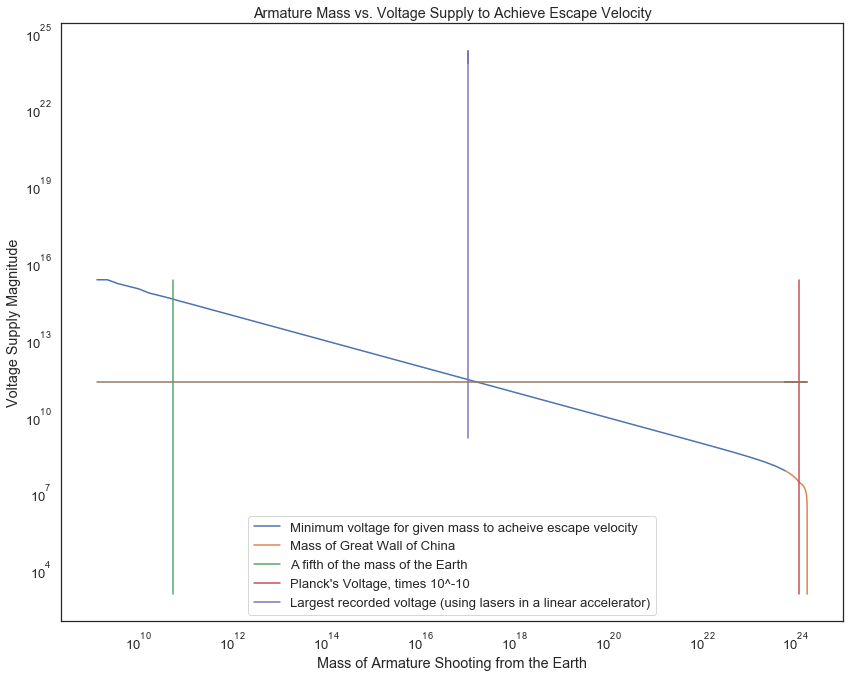

In [39]:
plt.figure(1)
plt.figure(figsize=[14,11])
plt.loglog(fin_vs.index, fin_vs.values,
           fin_m.values, fin_m.index,
           great_wall.index, great_wall.values,
           mass_earth_fifth.index, mass_earth_fifth.values, 
           planck_voltage.values, planck_voltage.index, 
           max_l_rec_voltage.index, max_l_rec_voltage.values)
plt.xlabel('Mass of Armature Shooting from the Earth')
plt.ylabel('Voltage Supply Magnitude')
plt.title('Armature Mass vs. Voltage Supply to Achieve Escape Velocity')
plt.legend(['Minimum voltage for given mass to acheive escape velocity',
            'Mass of Great Wall of China', 
            'A fifth of the mass of the Earth', 
            'Planck\'s Voltage, times 10^-10', 
            'Largest recorded voltage (using lasers in a linear accelerator)'])

In [41]:
params_railgun = Params(params_railgun, mass = 1.8*10**24*kg, Vs = 1*10**3*V)
post_cannon_earth_velocity,post_cannon_earth_mass = launch_simulation(params_railgun.mass, params_railgun.Vs, params_railgun, orbital_results)
post_cannon_results = run_planet_simulation(get_last_value(orbital_results.xpos),get_last_value(orbital_results.ypos),post_cannon_earth_velocity.x,post_cannon_earth_velocity.y, post_cannon_earth_mass,1)


,xpos,ypos,xvel,yvel
0.000000,1.495972e+11,4.482013e+08,-127.769198,42635.479750
0.716586,1.495972e+11,4.482318e+08,-127.773448,42635.479737
1.000000,1.495972e+11,4.482439e+08,-127.775129,42635.479732


<Figure size 432x288 with 0 Axes>

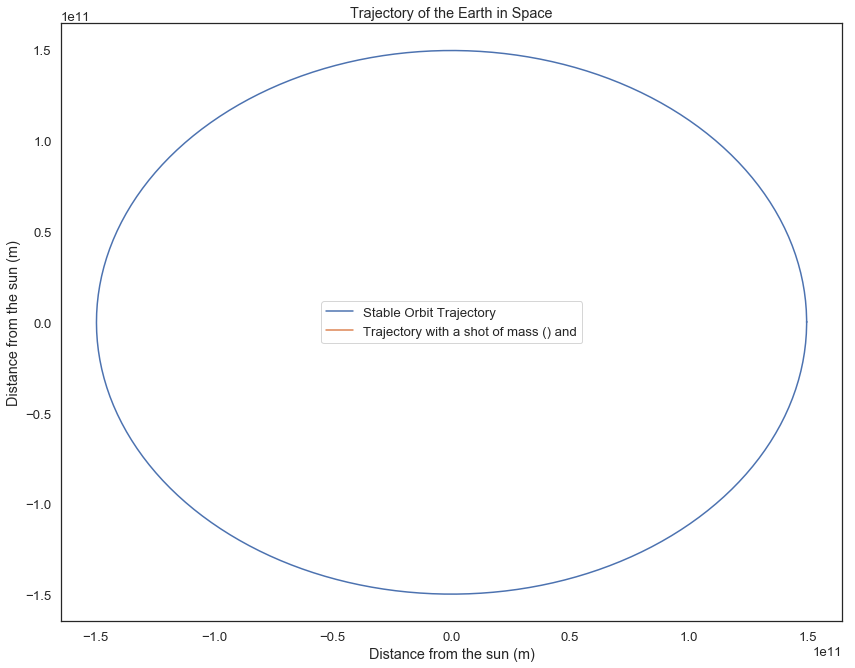

In [42]:
plt.figure(2)
plt.figure(figsize=[14,11])
plt.plot(orbital_results.xpos, orbital_results.ypos,post_cannon_results.xpos, post_cannon_results.ypos)
plt.xlabel('Distance from the sun (m)')
plt.ylabel('Distance from the sun (m)')
plt.title('Trajectory of the Earth in Space')
plt.legend(['Stable Orbit Trajectory',
            'Trajectory with a shot of mass () and', 
            'A fifth of the mass of the Earth', 
            'Planck\'s Voltage, times 10^-10', 
            'Largest recorded voltage (using lasers in a linear accelerator)'])